In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
road_root = "dataset/data_road"
road_img_train_path = os.path.join(road_root, "training/image_2")
road_gt_train_path = os.path.join(road_root, "training/gt_image_2")
road_img_test_path = os.path.join(road_root, "testing/image_2")

In [3]:
road_img_names = os.listdir(road_img_train_path)

In [4]:
rand_idx = int(np.random.rand() * len(road_img_names))
img_name = road_img_names[rand_idx]
print(f"Select image \'{img_name}\'.")
img = cv2.imread(os.path.join(road_img_train_path, img_name))
gt = cv2.imread(os.path.join(road_gt_train_path, f"{img_name.split('_')[0]}_road_{img_name.split('_')[1]}"))

Select image 'um_000036.png'.


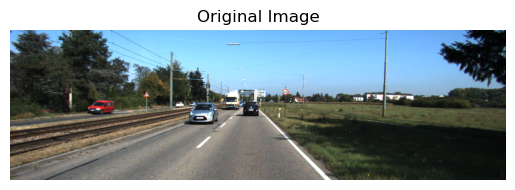

In [5]:
def imshow(img, title=None):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')  
    plt.title(title)
    plt.show()

height, width, channel = img.shape
imshow(img, "Original Image")

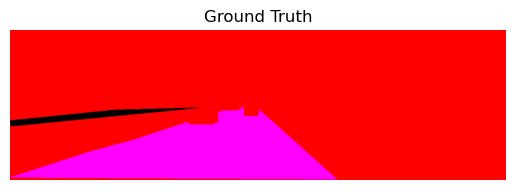

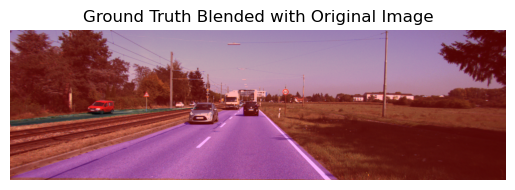

In [6]:
def show_gt(img, gt):
    result = cv2.addWeighted(img.copy(), 0.7, gt.copy(), 0.3, 0)
    imshow(gt, "Ground Truth")
    imshow(result, "Ground Truth Blended with Original Image")
    return result
img_gt = show_gt(img, gt)

In [7]:
# Gray, blur and edge detection
def preprocess(image, canny_threshold1, canny_threshold2):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, canny_threshold1, canny_threshold2)
    return edges

# Select the lower part as region of interest
def roi(img):
    height, width = img.shape
    mask = np.zeros_like(img)
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)
    cv2.fillPoly(mask, roi_vertices, 255)
    return cv2.bitwise_and(img, mask)


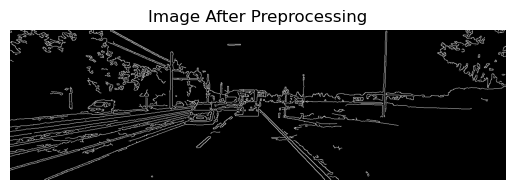

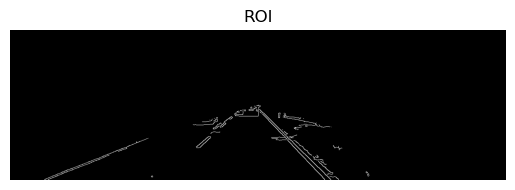

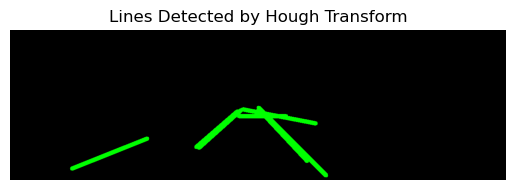

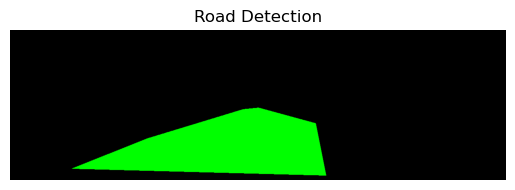

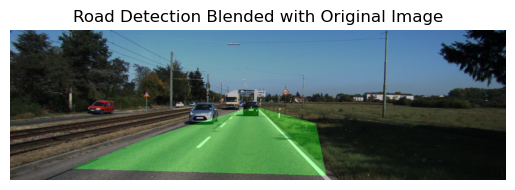

In [8]:
def detect_road(img, buffer=10, canny_threshold1=50, canny_threshold2=150,
                      rho=1, theta=np.pi/180, hough_threshold=50, min_line_length=100, max_line_gap=50):
    height, width = img.shape[:2]

    # Preprocess
    image = img.copy()
    edges = preprocess(image, canny_threshold1, canny_threshold2)
    imshow(edges, "Image After Preprocessing")

    # Select the lower part as the region of interest
    mask = np.zeros_like(edges)
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)
    cv2.fillPoly(mask, roi_vertices, 255)
    masked_edges = roi(edges)
    imshow(masked_edges, "ROI")

    # Hough transform: lane detection
    lines = cv2.HoughLinesP(masked_edges, rho, theta, hough_threshold, np.array([]),
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    line_image = np.zeros_like(image)
    road_polygon = []

    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                # Filter lines that are close to the boundary, 
                # since the boundaries after cropping are also lines 
                if (x1 > buffer and y1 > buffer and x2 > buffer and y2 > buffer
                    and x1 < width - buffer and y1 < height - buffer
                    and x2 < width - buffer and y2 < height - buffer):
                    road_polygon.extend([(x1, y1), (x2, y2)])
                    cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 10)

    imshow(line_image, "Lines Detected by Hough Transform")

    if len(road_polygon) > 0:
        road_polygon = np.array(road_polygon)
        hull = cv2.convexHull(road_polygon)  
        fill_image = np.zeros_like(image)
        cv2.fillPoly(fill_image, [hull], (0, 255, 0))  
        final_image = cv2.addWeighted(image, 0.7, fill_image, 0.3, 0)
    else:
        final_image = image
        fill_image = np.zeros_like(image, dtype=np.float32)
    imshow(fill_image, "Road Detection")
    imshow(final_image, "Road Detection Blended with Original Image")
    return final_image, fill_image
    
detection_img, detection_segmentation = detect_road(img)

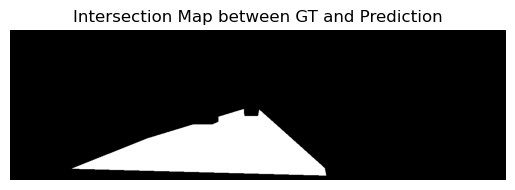

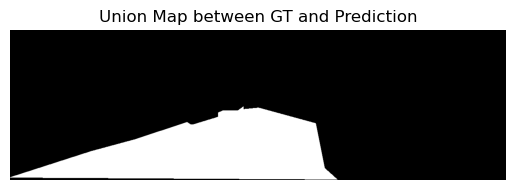

IoU = 0.6633949932893739


In [9]:
def compute_iou(gt_image, fill_image):
    hsv_gt = cv2.cvtColor(gt_image, cv2.COLOR_BGR2HSV)
    lower_purple = np.array([130, 50, 50]) 
    upper_purple = np.array([160, 255, 255])
    gt_mask = cv2.inRange(hsv_gt, lower_purple, upper_purple)
    fill_gray = cv2.cvtColor(fill_image, cv2.COLOR_BGR2GRAY)
    _, fill_mask = cv2.threshold(fill_gray, 1, 255, cv2.THRESH_BINARY)

    intersection = np.logical_and(gt_mask, fill_mask)
    union = np.logical_or(gt_mask, fill_mask)

    imshow(intersection.astype(np.float32), "Intersection Map between GT and Prediction")
    imshow(union.astype(np.float32), "Union Map between GT and Prediction")
    iou = intersection.sum() / union.sum() if union.sum() != 0 else 0
    return iou
    
print("IoU =", compute_iou(gt, detection_segmentation))